In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

<h2> Информационный поиск. Домашняя работа 1 </h2>
<h3> Валерий Дужик </h3>

Сначала надо достать данные:

In [2]:
def parse(filename, fields):
    result = []
    d = {}
    idx = 1
    key, value = None, None 
    
    with open(filename) as docs_file: 
        lines = docs_file.readlines()
        for line in lines: 
            line = line[:-1]
            if line.startswith('.I '):
                if idx > 1:
                    if not key is None:
                        d[key] = '\n'.join(value)
                    result.append(d) 
                d = { 'idx' : idx }
                d['.I'] = line[3:]
                idx += 1
                key, value = None, None 
                
            elif line in fields:
                if not key is None:
                    d[key] = '\n'.join(value)
                key = line
                value = []
                
            elif not value is None:
                value.append(line)
    
    if 'idx' in d:
        result.append(d)
        
    return result
        
docs = parse('data/cran.all.1400', ['.T', '.A', '.B', '.W'])
queries = parse('data/cran.qry', ['.W'])

assert(len(docs) == 1400)
assert(docs[0]['.T'] == '''experimental investigation of the aerodynamics of a\nwing in a slipstream .''')

assert(len(queries) == 225)
assert(queries[0]['.W'] == '''what similarity laws must be obeyed when constructing aeroelastic models\nof heated high speed aircraft .''')

Нормализовывать тексты я думаю как-то так:

In [3]:
import nltk

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [56]:
from nltk.tokenize import word_tokenize

from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

from nltk.corpus import stopwords

lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('english', False)

stop_words = set(stopwords.words('english'))

def tokenize_and_normalize(text, stemming=True):
    tokens = []
    if stemming:
        tokens = [stemmer.stem(token) for token in word_tokenize(text) if token.isalpha()]
    else:
        tokens = [lemmatizer.lemmatize(token) for token in word_tokenize(text) if token.isalpha()]
        
    return [token for token in tokens if not token in stop_words]

split_and_normalize('experimental investigation of the aerodynamics of a\nwing in a slipstream .', False)

['experimental', 'investigation', 'aerodynamics', 'wing', 'slipstream']

Приготовления закончены, можно строить индекс.

In [122]:
from collections import Counter, defaultdict


def build_inverse_index(data, field): 
    result = defaultdict(list)
    lengths = {}
    sum_lengths = 0
    
    for doc in data:
        dId = int(doc['.I'])
        if field in doc:
            tokens = tokenize_and_normalize(doc[field])  
            lengths[dId] = len(tokens)
            sum_lengths += len(tokens) 

            counter = Counter(tokens)   
            for token in counter:
                result[token].append((dId, counter[token]))
                 
    return result, lengths, sum_lengths/len(lengths)

In [123]:
def GetL1Result(query_tokens, index):
    result = defaultdict(dict)
    
    for token in query_tokens:
        for df in index[token]:
            result[df[0]][token] = df[1]
            
    return [(dId, defaultdict(float, result[dId])) for dId in result]

In [193]:
from math import log

def CalcRSV(query_tokens, doc_match_dict, Nt, params):
    b, k1 = params['b'], params['k1'] 
    L_rel = params['Ld'] / params['Lavg']
    N = params['N']
    res = None
    if not 'k2' in params:
        res = [log(1 + (N - Nt[token] + 0.5)/(Nt[token] + 0.5)) \
               * doc_match_dict[token]*(k1 + 1) / (k1 * (1 - b + b*L_rel) + doc_match_dict[token]) \
               for token in query_tokens]
    else:
        k2 = params['k2']
        Fq = Counter(query_tokens)
        
        res = [log(1 + (N - Nt[token] + 0.5)/(Nt[token] + 0.5)) \
               * doc_match_dict[token]*(k1 + 1) / (k1 * (1 - b + b*L_rel) + doc_match_dict[token]) \
               * Fq[token]*(1 + k2) / (k2 + Fq[token]) \
               for token in Fq]
    return sum(res)

def GetTopRSV(query, index, lengths, avg_length, params):
    params['N'] = len(lengths)
    params['Lavg'] = avg_length
    
    query_tokens = tokenize_and_normalize(query) 
    Nt = { token : len(index[token]) for token in query_tokens }
    
    L1_result = GetL1Result(query_tokens, index)
    
    result = []
    
    for doc, match_dict in L1_result:
        params['Ld'] = lengths[doc]
        result.append((doc, CalcRSV(query_tokens, match_dict, Nt, params)))
            
    result.sort(key=lambda x : x[1], reverse=True) 
    return result[:10]

In [194]:
def GetQueriesTopRsv(for_all, b, k1, k2=None):
    index, lengths, avg_length = None, None, None
    if for_all:
        index, lengths, avg_length = build_inverse_index(docs, '.W')
    else:
        index, lengths, avg_length = build_inverse_index(docs, '.T')
    
    params = {
        'b' : b,
        'k1' : k1
    }
    if not k2 is None:
        params['k2'] = k2
    
    result = {}
    for idx, query_rec in enumerate(queries):
        if '.W' in query_rec:
            top_relevant = GetTopRSV(query_rec['.W'], index, lengths, avg_length, params)
            result[idx + 1] = [dId for dId, rel in top_relevant] 
            
    return result
    
RSV_baseline_all = GetQueriesTopRsv(True, 0.75, 1.2)
RSV_baseline_header = GetQueriesTopRsv(False, 0.75, 1.2)

Для более удобного дальнейшего GridSearch вынесу eval.py сюда:

In [159]:
def Eval(q2retrd):
    groundtruth_file = 'data/qrel_clean' 

    q2reld = {} 
    for line in open(groundtruth_file):
        qid, did = [int(x) for x in line.split()]
        if qid in q2reld.keys():
            q2reld[qid].add(did)
        else:
            q2reld[qid] = set()

    N = len(q2retrd.keys())
    precision = sum([len(q2reld[q].intersection(q2retrd[q]))*1.0/len(q2retrd[q]) for q in q2retrd.keys()]) / N
    recall = sum([len(q2reld[q].intersection(q2retrd[q]))*1.0/len(q2reld[q]) for q in q2retrd.keys()]) / N
    print("mean precision: {}\nmean recall: {}\nmean F-measure: {}"\
          .format(precision, recall, 2*precision*recall/(precision+recall)))

    # MAP@10 

    MAP = 0.0
    for q in q2retrd.keys():
        n_results = min(10, len(q2retrd[q]))
        avep = np.zeros(n_results)
        for i in range(n_results):
            avep[i:] += q2retrd[q][i] in q2reld[q]
            avep[i] *= (q2retrd[q][i] in q2reld[q]) / (i+1.0)
        MAP += sum(avep) / min(n_results, len(q2reld[q]))
    print("MAP@10: {}".format(MAP/N))
    

# Для grid-search пригодится такая версия.
def CalcMap10(q2retrd):
    groundtruth_file = 'data/qrel_clean' 

    q2reld = {} 
    for line in open(groundtruth_file):
        qid, did = [int(x) for x in line.split()]
        if qid in q2reld.keys():
            q2reld[qid].add(did)
        else:
            q2reld[qid] = set()
            
    N = len(q2retrd.keys())
    
    MAP = 0.0
    for q in q2retrd.keys():
        n_results = min(10, len(q2retrd[q]))
        avep = np.zeros(n_results)
        for i in range(n_results):
            avep[i:] += q2retrd[q][i] in q2reld[q]
            avep[i] *= (q2retrd[q][i] in q2reld[q]) / (i+1.0)
        MAP += sum(avep) / min(n_results, len(q2reld[q]))
    return MAP/N

In [185]:
Eval(RSV_baseline_header)

mean precision: 0.195089285714286
mean recall: 0.34153334335896685
mean F-measure: 0.24832905805177075
MAP@10: 0.24925218223036563


In [186]:
Eval(RSV_baseline_all)

mean precision: 0.23928571428571463
mean recall: 0.415043741385878
mean F-measure: 0.30355973510439327
MAP@10: 0.3191615362249399


Какое-то невпечатляющее качество. Надеюсь, так и надо. 
Как бы то ни было, качество на полных аннотациях оказалось лучше. 

In [164]:
nsteps = 10

MAP10_RSV_all = np.zeros((nsteps,nsteps))

for x, k1 in enumerate(np.linspace(1.2, 2., nsteps)):
    for y, b in enumerate(np.linspace(0., 1., nsteps)): 
        MAP10_RSV_all[x, y] = CalcMap10(GetQueriesTopRsv(True, b, k1))

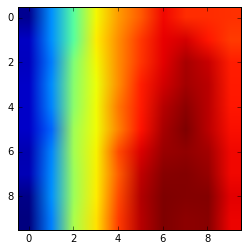

In [172]:
plt.imshow(MAP10_RSV_all)

Разницы по параметру k1 почти никакой, а вот b лучше взять в районе 0.7.  
k1, в таком случае, лучше взять около 1.6: получим MAP@10 = 0.32721281828703724. Немного, да улучшили.

Интуиция примерно такая: нулевое значение b соответсвует игнорированию длины документа, вот там и просела метрика.


>Попробуйте нормировать RSV (q, d) на сумму IDF термов запроса.

Можно, но это не изменит ничего, потому что все реллевантности просто будут домножены на одно и то же число в рамках одного запроса.

А вот новый BM посчитать можно. В параметры добавляется k2:

In [195]:
RSV_k2_all = [CalcMap10(GetQueriesTopRsv(True, 0.75, 1.2, k2)) for k2 in np.logspace(-2, 3, 6)]

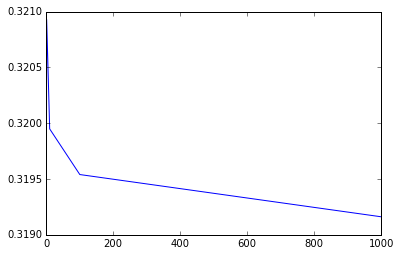

In [196]:
plt.plot(np.logspace(-2, 3, 6), RSV_k2_all)

Получается, что лучше передать сюда 0, тогда коэффициент k2 не учитывается. Видимо, я недопонял слайд лекции.